In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr

import kdephys.hypno as kh
import kdephys.pd as kpd
import kdephys.xr as kx
import kdephys.utils as ku
import kdephys.ssfm as ss

import acr.subjects as subs
import acr
import acr.utils as acu
import plotly.express as px

/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
root = '/Volumes/opto_loc/Data/ACR_14/'

In [3]:
lx = ['laser1-bl', 'laser1', 'laser1-post1']
sdx = ['sdpi-bl', 'sdpi', 'sdpi-post']

In [4]:
def check_sig(root, x_list, store='NNXr'):
    for x in x_list:
        path = f'{root}/{x}-{store}.nc'
        data = xr.open_dataarray(path)
        end = data.datetime.values.max()
        chan = data.channel.values[-1]
        start = end - np.timedelta64(10, 's')
        data_plot = data.sel(datetime=slice(start, end), channel=chan)
        f, ax = plt.subplots()
        ax.plot(data_plot.datetime.values, data_plot.values)
    return
    

In [17]:
def check_rec(root, rec, store, t1, t2):
    path = f'{root}/{rec}-{store}.nc'
    data = xr.open_dataarray(path)
    chan = data.channel.values[-1]
    data = data.swap_dims({'datetime': 'time'})
    data_plot = data.sel(time=slice(t1, t2), channel=chan)
    f, ax = plt.subplots(figsize=(20, 7))
    ax.plot(data_plot.time.values, data_plot.values)
    return ax

(-400.0, 400.0)

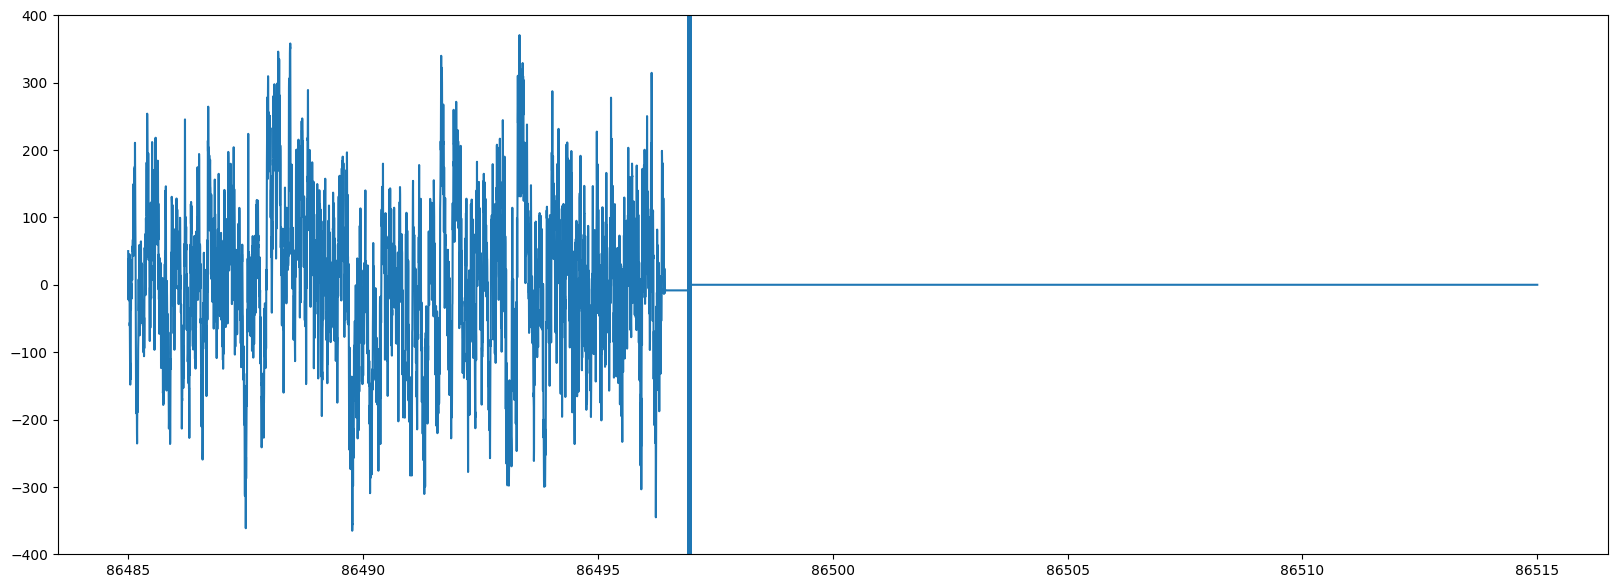

In [18]:
ax = check_rec(root, 'sdpi-bl', 'NNXr', 86485, 86515)
ax.set_ylim(-400, 400)

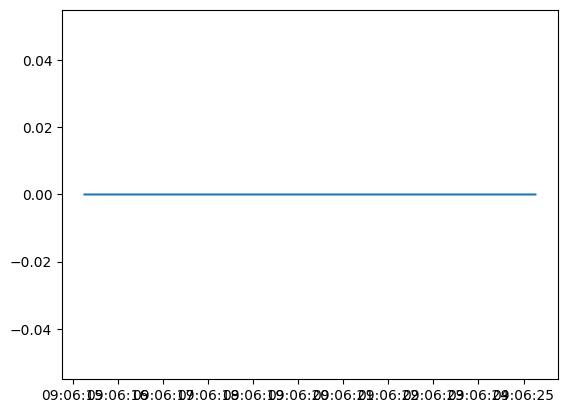

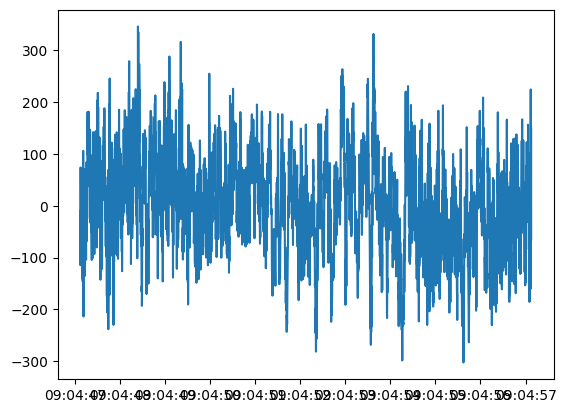

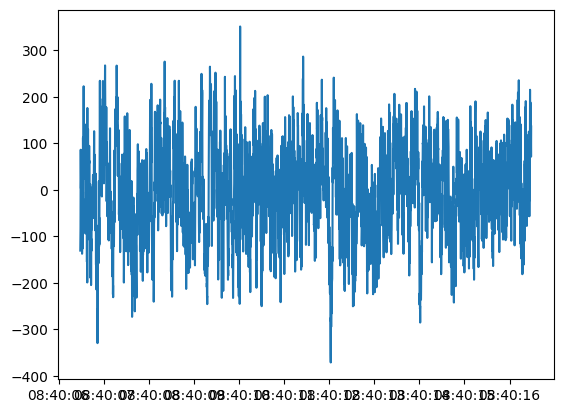

In [6]:
check_sig(root, sdx)

In [35]:
plt.style.use('acr_plots.mplstyle')
def acr_bp_plot(ddr, exp, ts, chans=(3, 13), band='delta', state=None, smooth=False, period='Late Sleep Rebound'):
    """
    ddr: data dictionary (bandpower set relative to bl)
    exp: experiment name
    ts: time slice
    chans: channels to plot
    band: band to plot
    state: plot ONLY data in this state
    smooth: smooth data with a 4-sample gaussian kernel
    """
    x1 = exp + '-LFP_'
    x2 = exp + '-LFPo'
    if (state!=None):
        ddr_ss = {}
        for key in ddr.keys():
            ddr_ss[key] = ddr[key].where(ddr[key].state == state, drop=True)
        if smooth:
            ddr_ss_sm = {}
            for key in ddr_ss.keys():
                ddr_ss_sm[key] = kx.utils.get_smoothed_ds(ddr_ss[key], smoothing_sigma=4)
            dd = ddr_ss_sm
        elif smooth == False:
            dd = ddr_ss
    elif state==None:
        if smooth:
            ddr_sm = {}
            for key in ddr.keys():
                ddr_sm[key] = kx.utils.get_smoothed_ds(ddr[key], smoothing_sigma=4)
            dd = ddr_sm
    elif (state==None) & (smooth==False):
        dd = ddr
    f, ax = plt.subplots(2, 1, figsize=(25, 15))
    ax[0].plot(dd[x1][band].sel(datetime=ts, channel=chans[0]))
    ax[0].plot(dd[x2][band].sel(datetime=ts, channel=chans[0]))
    ax[1].plot(dd[x1][band].sel(datetime=ts, channel=chans[1]))
    ax[1].plot(dd[x2][band].sel(datetime=ts, channel=chans[1]))
    if state:
        f.suptitle(band + ' Bandpower, ' + state + '-ONLY, ' + period)
    else:
        f.suptitle(band + ' Bandpower, ALL states, ' + period)
    f.supylabel("Bandpower (% of BL)")
    f.supxlabel("Time")
    ax[0].set_title('Superficial LFP')
    ax[1].set_title('Deep LFP')
    ax[0].axhline(1, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='r', linestyle='--')
    ax[1].axhline(1, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color='r', linestyle='--')
    return f, ax

In [61]:
a13, s13, b13, h13 = acr.io.acr_load_master(subs.a13, type='pandas', stores=['LFP_', 'LFPo'])

read from t=0s to t=43975.18s
Using 610.3516 Hz as SEV sampling rate for LFP_
read from t=0s to t=43975.18s
Using 610.3516 Hz as SEV sampling rate for LFPo
read from t=14027s to t=36096.85s
Using 610.3516 Hz as SEV sampling rate for LFP_
read from t=14027s to t=36096.85s
Using 610.3516 Hz as SEV sampling rate for LFPo


In [62]:
a14, s14, b14, h14 = acr.io.acr_load_master(subs.a14, type='pandas', stores=['LFP_', 'LFPo'])

read from t=0s to t=44399.22s
Using 610.3516 Hz as SEV sampling rate for LFP_
read from t=0s to t=44399.22s
Using 610.3516 Hz as SEV sampling rate for LFPo
read from t=13999s to t=36202.21s
Using 610.3516 Hz as SEV sampling rate for LFP_
read from t=13999s to t=36202.21s
Using 610.3516 Hz as SEV sampling rate for LFPo


In [183]:
for key in b13.keys():
    b13[key].to_parquet('b13-'+key+'.parquet', version='2.6')

In [17]:
def rel_bp(dd, exp, rel2, state, stores=['-LFP_', '-LFPo'], avg='median'):
    """
    dd: bandpower dataset
    exp: experiment name
    rel2: experiment to get baseline from, typically 'exp-bl
    state: use data in rel2 from only this state
    stores: stores to use
    avg: how to average across time
    """
    
    rel2_keys = [rel2+store for store in stores]
    exp_keys = [exp+store for store in stores]
    

In [ ]:
b13_nrem = {}
b13_nrem['laser1-bl-LFP_'] = kh.keep_states(b13['laser1-bl-LFP_'], h13['laser1-bl'], ['NREM'])
b13_nrem['laser1-bl-LFPo'] = kh.keep_states(b13['laser1-bl-LFPo'], h13['laser1-bl'], ['NREM'])

b13_rel = {}

b13_rel['laser1-LFP_'] = b13['laser1-LFP_']/b13_nrem['laser1-bl-LFP_'].median(dim='datetime')
b13_rel['laser1-LFPo'] = b13['laser1-LFPo']/b13_nrem['laser1-bl-LFPo'].median(dim='datetime')
a13_pi = acu.tdt_to_dt(subs.a13, a13['laser1-LFP_'], 'laser1-pi')
t = acu.tdt_to_dt(subs.a13, a13['laser1-LFP_'], 'laser1-pi', slc=False)
rs13_on = t[1] + pd.to_timedelta(2, unit='H')
rs13_off = rs13_on + pd.to_timedelta(3, unit='H')
a13_rs = slice(rs13_on, rs13_off)

In [ ]:
b14_nrem = {}
b14_nrem['laser1-bl-LFP_'] = kh.keep_states(b14['laser1-bl-LFP_'], h14['laser1-bl'], ['NREM'])
b14_nrem['laser1-bl-LFPo'] = kh.keep_states(b14['laser1-bl-LFPo'], h14['laser1-bl'], ['NREM'])

b14_rel = {}

b14_rel['laser1-LFP_'] = b14['laser1-LFP_']/b14_nrem['laser1-bl-LFP_'].median(dim='datetime')
b14_rel['laser1-LFPo'] = b14['laser1-LFPo']/b14_nrem['laser1-bl-LFPo'].median(dim='datetime')
a14_pi = acu.tdt_to_dt(subs.a14, a14['laser1-LFP_'], 'laser1-pi')
t = acu.tdt_to_dt(subs.a14, a14['laser1-LFP_'], 'laser1-pi', slc=False)
rs14_on = t[1] + pd.to_timedelta(2, unit='H')
rs14_off = rs14_on + pd.to_timedelta(3, unit='H')
a14_rs = slice(rs14_on, rs14_off)

In [ ]:
def get_ons_time(info, exp, t1=14000):
    """returns the times where Wav2 store is greater than 1.5, which should equal the laser on times
    """
    t2 = t1+10000
    wav = tdt.read_block(info['paths'][exp], evtype=['streams'], store='Wav2', t1=t1, t2=t2)
    fs = wav.streams.Wav2.fs
    samp = len(wav.streams.Wav2.data)
    time = np.arange(0, samp) / fs + t1
    data = wav.streams.Wav2.data
    wavx = xr.DataArray(data, dims=['time'], coords={'time': time})
    wavx_on = wavx.where(wavx>1.5, drop=True)
    on = wavx_on.time.min()
    off = wavx_on.time.max()
    return on, off

In [ ]:
on13, off13 = get_ons_time(subs.a13, 'laser1')
print(on13)
print(off13)

In [ ]:
on14, off14 = get_ons_time(subs.a14, 'laser1')
print(on14)
print(off14)

# Subject Information

Both subjects have the same exact general layout:

![](ref/a14_overview.jpg)

BUT, both of the probes in ACR_13 have 100um channel spacing, while ACR_14's probes have 50um spacing, here's what the optrode looks like for each subject:

![](ref/a13_coronal.jpg)

![](ref/a14_coronal.jpg)

# Experiment Design

Both subjects had the same exact experiment design:

![](ref/x_des.jpg)

# Question 1 - Did the ~30min silencing period work?

## ACR_13

This subject has something weird going on.... it appears that delta power was NOT suppressed, but Gamma power clearly was suppressed by the photoinhibition:

In [ ]:
f, ax = acr_bp_plot(b13_rel, 'laser1', ts=a13_pi, chans=(3, 13), band='delta', state=None, smooth=True, period='Early-Rebound with Photoinhibition')
ax[0].set_ylim(0, 4);
ax[1].set_ylim(0, 4);

In [ ]:
f, ax = acr_bp_plot(b13_rel, 'laser1', ts=a13_pi, chans=(3, 13), band='low_gamma', state=None, smooth=True, period='Early-Rebound with Photoinhibition')
ax[0].set_ylim(0, 2);
ax[1].set_ylim(0, 2);

## ACR_14

This subject was much closer to expected: both Delta AND Gamma bandpower were clearly supressed during the photoinhibtion:

Note however that while the delta power was clearly suppressed, it was still notably above the baseline median (at least for the deep channel):

In [ ]:
f, ax = acr_bp_plot(b14_rel, 'laser1', ts=a14_pi, chans=(2, 14), band='delta', state=None, smooth=True, period='Early-Rebound with Photoinhibition')
ax[0].set_ylim(0, 6);
ax[1].set_ylim(0, 6);

Gamma suppression very effective for the superficial channel:

In [ ]:
f, ax = acr_bp_plot(b14_rel, 'laser1', ts=a14_pi, chans=(2, 14), band='low_gamma', state=None, smooth=True, period='Early-Rebound with Photoinhibition')
ax[0].set_ylim(0, 3);
ax[1].set_ylim(0, 3);

# Question 2: What happened during the Late-Rebound period?

## ACR_13

In [ ]:
f, ax = acr_bp_plot(b13_rel, 'laser1', ts=a13_rs, chans=(3, 13), band='delta', state=None, smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 6);
ax[1].set_ylim(0, 6);

The wake artifact makes this a little messy, so here is ONLY the NREM data:

In [ ]:
f, ax = acr_bp_plot(b13_rel, 'laser1', ts=a13_rs, chans=(3, 13), band='delta', state='NREM', smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 5.5);
ax[1].set_ylim(0, 5.5);

In [ ]:
f, ax = acr_bp_plot(b13_rel, 'laser1', ts=a13_rs, chans=(3, 13), band='low_gamma', state=None, smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 2);
ax[1].set_ylim(0, 2);

It is very unclear what is going on with this subject. 

My best guess at this point is that for some reason, the delta on the photoinhibition side is above what it should be, though I don't know how or why that would be the case. If this were true, then it is likely that the photoinhibition DID work, and that the delta is NOT elevated in the late-rebound. That also does not match with the fact that the gamma suppression seemed to work, although maybe that effect was so large we still see it with this weird thing happening. I find the data from ACR_14 more trustworthy:

## ACR_14

In [ ]:
f, ax = acr_bp_plot(b14_rel, 'laser1', ts=a14_rs, chans=(2, 14), band='delta', state=None, smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 6);
ax[1].set_ylim(0, 6);

Again here is the NREM only:

In [ ]:
f, ax = acr_bp_plot(b14_rel, 'laser1', ts=a14_rs, chans=(2, 14), band='delta', state='NREM', smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 6);
ax[1].set_ylim(0, 6);

In [ ]:
f, ax = acr_bp_plot(b14_rel, 'laser1', ts=a14_rs, chans=(2, 14), band='low_gamma', state=None, smooth=True, period='Late-Rebound')
ax[0].set_ylim(0, 3);
ax[1].set_ylim(0, 3);

By the time we get to the late-rebound in this subject, there is almost NO sign of any difference in high or low frequencies - it was as if the photoinhibition 2-hours earlier didn't happen. 

Or, perhaps there is a 'ceiling' of sleep pressure that we are hitting, so even if we are building on top of unrelieved pressure from the photoinhibtion period, we are hitting an upper limit where we can't see it. This seems unlikely since the second SD immediately preceding the late-rebound was only 2-hours. 

# What is going on with ACR_13's data?

In [68]:
a13 = {}
a13["subject"] = "ACR_13"
a13["complete_key_list"] = ["laser1-post1"]
a13["paths"] = acr.io.get_acr_paths(a13["subject"], a13["complete_key_list"])
a13["load_times"] = {}
a13["load_times"]["laser1-bl"] = (0, 12)
a13["load_times"]["laser1"] = (14027, 6)
a13["load_times"]["laser1-post1"] = (0, 6)
a13["load_times"]["laser1-post2"] = (0, 6)
a13["channels"] = {}
a13["channels"]["EEGr"] = [1, 2]
a13["channels"]["NNXr"] = list(range(1, 17))
a13["channels"]["LFP_"] = [3, 13]
a13["channels"]["LFPo"] = [3, 13]
a13["channels"]["NNXo"] = list(range(1, 17))

a13["times"] = {}
a13["times"]["laser1-pi"] = (16367.83562112, 18097.09928446)

In [69]:
f, t, bp13, hp13 = acr.io.acr_load_master(a13, type='pandas', stores=['LFP_', 'LFPo'])


read from t=0s to t=22457.81s
Using 610.3516 Hz as SEV sampling rate for LFP_
read from t=0s to t=22457.81s
Using 610.3516 Hz as SEV sampling rate for LFPo


In [70]:
bp = bp13['laser1-post1-LFP_']
bo = bp13['laser1-post1-LFPo']

In [76]:
bp.xs(3, level='channel')

,time,delta,delta1,delta2,theta,alpha,sigma,beta,low_gamma,high_gamma,state,timedelta,condition
datetime,,,,,,,,,,,,,
2022-09-09 21:23:57.999666198,1.999667,12382.291016,1213.198486,8144.529785,9079.346680,5351.435059,3114.991943,4658.131836,1334.178589,499.228363,NREM,0 days 00:00:00,laser1-post1-LFP_
2022-09-09 21:24:00.000152597,4.000154,11633.384766,2168.701904,6069.965820,4826.566895,1885.876831,1302.396484,2414.604492,973.821594,345.264191,NREM,0 days 00:00:02.000486399,laser1-post1-LFP_
2022-09-09 21:24:02.000638995,6.000640,18188.015625,843.790283,7875.059570,16512.193359,3112.589111,2009.260620,4050.504883,1135.671997,496.541443,NREM,0 days 00:00:04.000972797,laser1-post1-LFP_
2022-09-09 21:24:04.001125393,8.001126,24293.300781,5616.677734,12066.560547,5596.330566,1761.350220,1706.519409,4453.942871,1444.754395,450.162781,NREM,0 days 00:00:06.001459195,laser1-post1-LFP_
2022-09-09 21:24:06.001611792,10.001613,46524.433594,3518.354248,27928.859375,6775.003906,2970.757080,2569.624023,4065.330811,1171.056641,333.062073,NREM,0 days 00:00:08.001945594,laser1-post1-LFP_
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-10 03:23:45.248390914,21589.248392,14131.195312,3332.919678,8800.910156,3334.548096,2657.908447,1968.302246,2839.313721,1645.775879,594.937317,Unsure,0 days 05:59:47.248724716,laser1-post1-LFP_
2022-09-10 03:23:47.248877312,21591.248878,14272.233398,5184.355957,2352.765625,12922.874023,7654.851562,4245.422363,5316.249512,2175.581299,445.982117,Unsure,0 days 05:59:49.249211114,laser1-post1-LFP_
2022-09-10 03:23:49.249363711,21593.249365,5762.617676,3519.817627,810.836304,10721.705078,7007.648926,3902.975098,5277.962891,1099.790894,304.034241,Unsure,0 days 05:59:51.249697513,laser1-post1-LFP_


In [86]:
bpn = bp.filt_state()
bon = bo.filt_state()

(0.0, 70000.0)

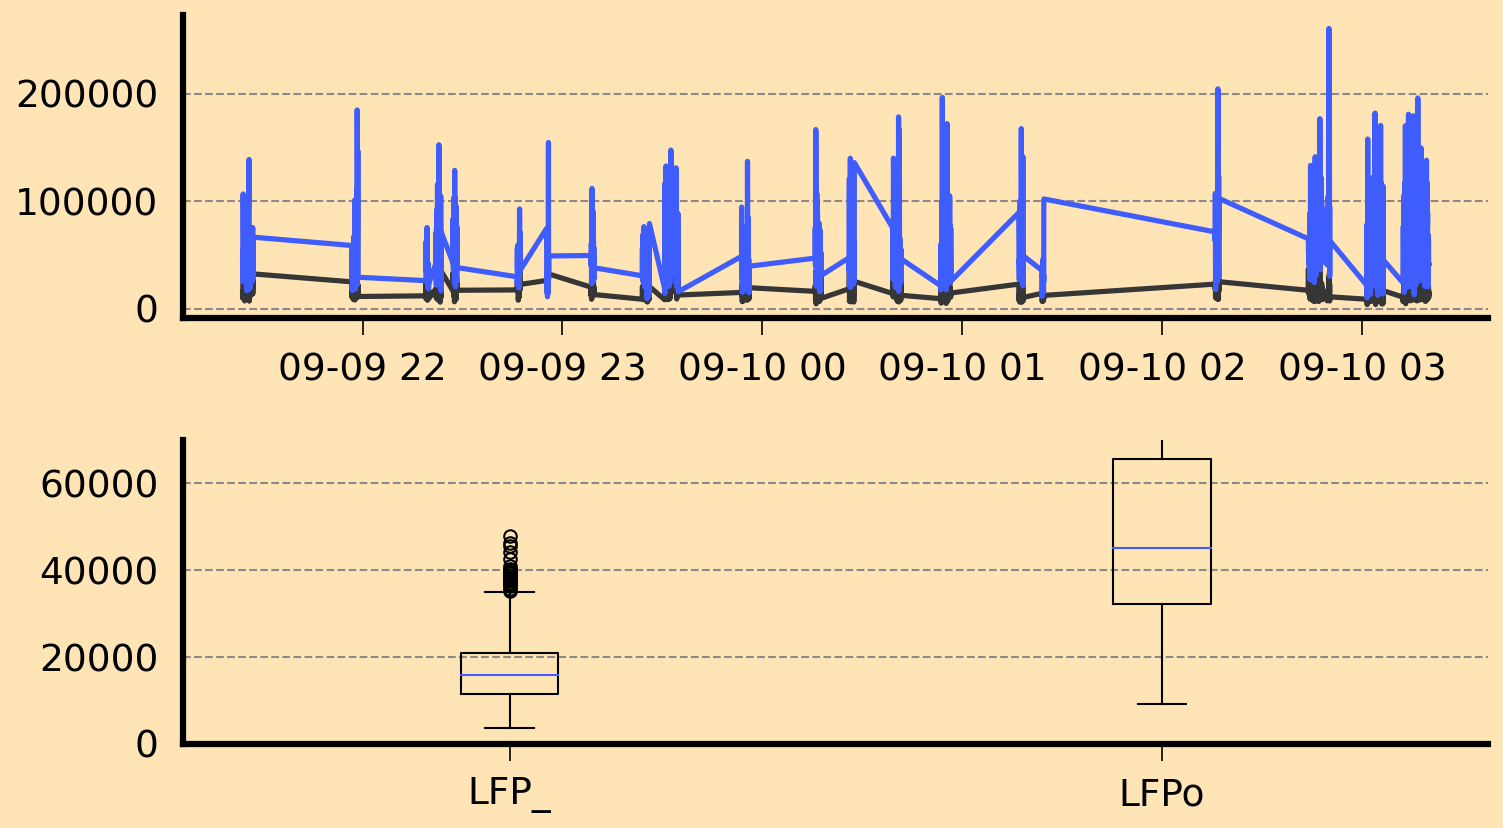

In [132]:
f, ax = plt.subplots(2, 1, sharex=False, figsize=(10, 6))
ax[0].plot(bpn.xs(13, level='channel').index, bpn.xs(13, level='channel').delta, label='LFP_')
ax[0].plot(bon.xs(13, level='channel').index, bon.xs(13, level='channel').delta, label='LFPo')
ax[1].boxplot([bpn.xs(13, level='channel').delta, bon.xs(13, level='channel').delta], labels=['LFP_', 'LFPo'])
ax[1].set_ylim(0, 70000)

In [109]:
# get all datetime values from index
dt = b13['laser1-LFP_'].ri()

In [115]:
# get all datetime values from index
list(b13['laser1-LFP_'].index.names)

['datetime', 'channel']

In [116]:
b13 = kpd.pd_utils.add_states_to_dataset(b13, h13)

<AxesSubplot:>

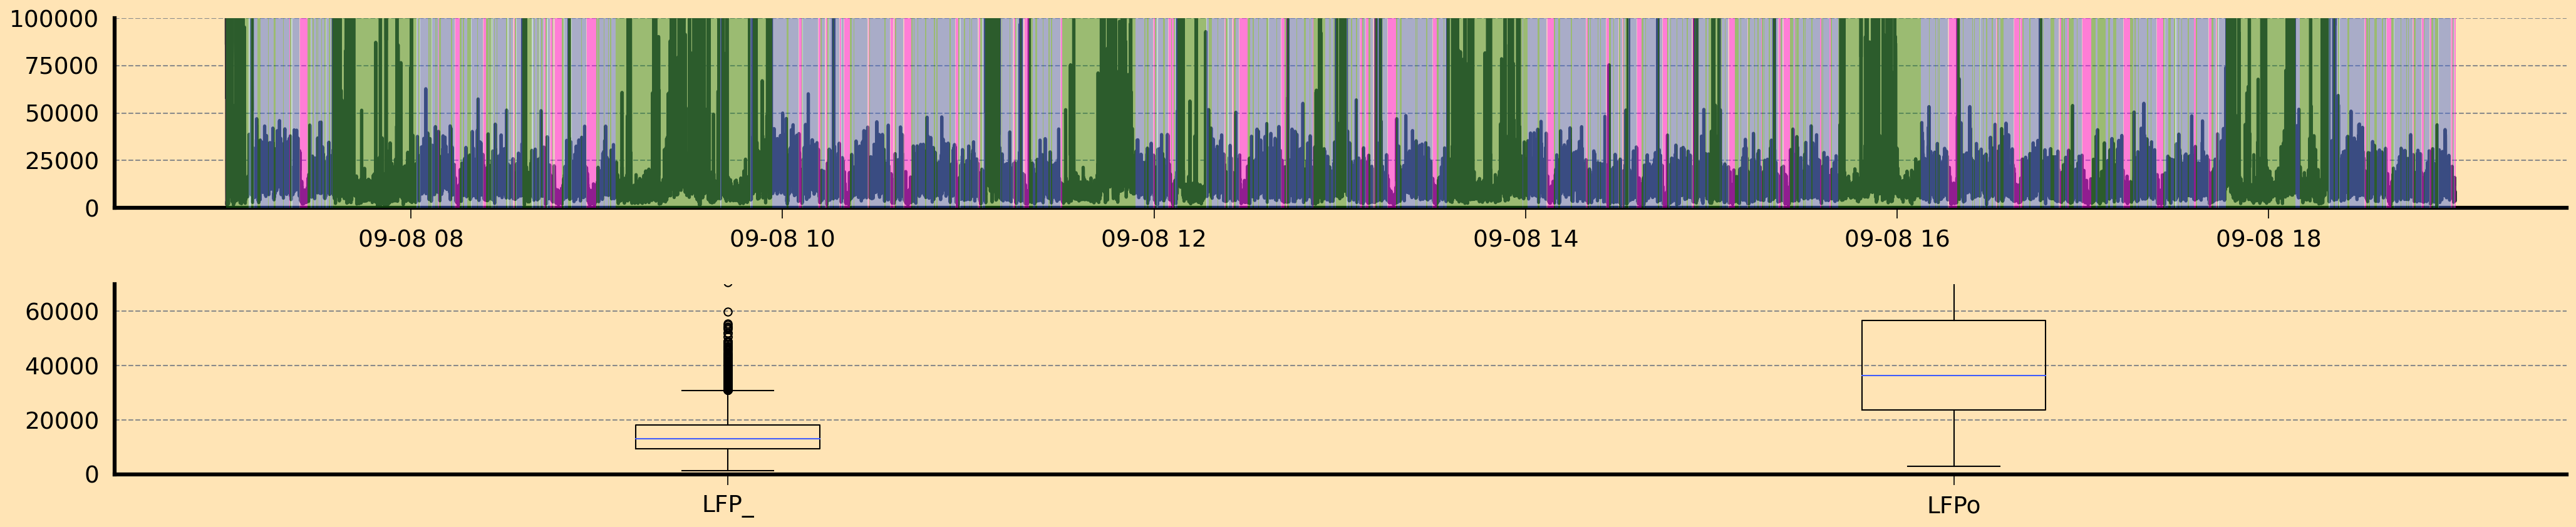

In [135]:
f, ax = plt.subplots(2, 1, figsize=(30, 6))
ax[0].plot(b13['laser1-bl-LFP_'].xs(13, level='channel').index, b13['laser1-bl-LFP_'].xs(3, level='channel').delta, label='LFP_')
ax[1].boxplot([b13['laser1-bl-LFP_'].xs(13, level='channel').filt_state().delta, b13['laser1-bl-LFPo'].xs(13, level='channel').filt_state().delta], labels=['LFP_', 'LFPo'])
ax[0].set_ylim(0, 100000)
ax[1].set_ylim(0, 70000)
kx.plots.shade_hypno_for_me(h13['laser1-bl'], ax[0])

In [147]:
pm = b13['laser1-LFP_'].filt_state().groupby(level='channel').mean()
om = b13['laser1-LFPo'].filt_state().groupby(level='channel').mean()

In [153]:
#expresss post data as a percentage of baseline
bp_rel = bp/pm
bo_rel = bo/pm
bp_rel['state'] = bp.state.values
bo_rel['state'] = bo.state.values

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7302b10670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7302b10c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7302b10310>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7302b111b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7302b11480>,
 'means': []}

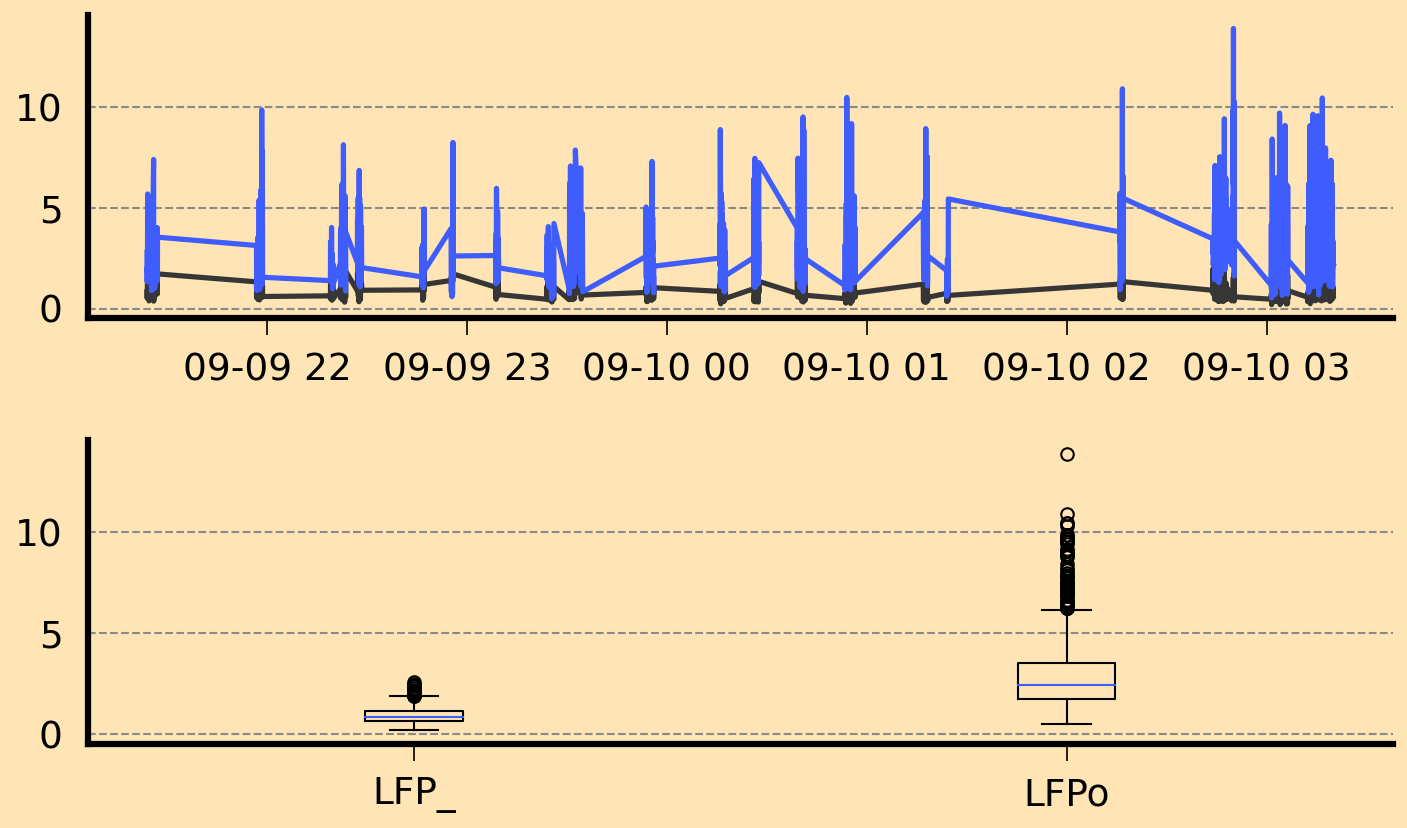

In [155]:
f, ax = plt.subplots(2, 1, sharex=False, figsize=(10, 6))
ax[0].plot(bp_rel.xs(13, level='channel').filt_state().index, bp_rel.xs(13, level='channel').filt_state().delta, label='LFP_')
ax[0].plot(bo_rel.xs(13, level='channel').filt_state().index, bo_rel.xs(13, level='channel').filt_state().delta, label='LFPo')
ax[1].boxplot([bp_rel.xs(13, level='channel').filt_state().delta, bo_rel.xs(13, level='channel').filt_state().delta], labels=['LFP_', 'LFPo'])

## Is this difference present during the baseline dark-period?

In [4]:
info_13 = {}
info_13["subject"] = "ACR_13"
info_13["complete_key_list"] = ["laser1"]
info_13["paths"] = acr.io.get_acr_paths(info_13["subject"], info_13["complete_key_list"])
info_13["load_times"] = {}
info_13["load_times"]["laser1-bl"] = (43200, 1)
info_13["load_times"]["laser1"] = (14027, 1)
info_13["load_times"]["laser1-post1"] = (0, 6)
info_13["load_times"]["laser1-post2"] = (0, 6)
info_13["channels"] = {}
info_13["channels"]["EEGr"] = [1, 2]
info_13["channels"]["NNXr"] = list(range(1, 17))
info_13["channels"]["LFP_"] = [3, 13]
info_13["channels"]["LFPo"] = [3, 13]
info_13["channels"]["NNXo"] = list(range(1, 17))

info_13["times"] = {}
info_13["times"]["laser1-pi"] = (16367.83562112, 18097.09928446)


In [5]:
f, t, dp, dh = acr.io.acr_load_master(info_13, type='pandas', stores=['LFP_'])

read from t=14027s to t=18565.16s
Using 610.3516 Hz as SEV sampling rate for LFP_


In [14]:
b13 = {}
keys = ['laser1-bl-LFP_', 'laser1-bl-LFPo']
for k in keys:
    key = 'b13-' + k + '.parquet'
    b13[k] = pd.read_parquet(key)

In [17]:
dh['laser1-bl']

,state,end_time,start_time,duration
0,Unsure,2022-09-08 19:05:34.130787693,2022-09-08 19:00:19.000782811,0 days 00:05:15.130004882
1,NREM,2022-09-08 19:06:26.040791356,2022-09-08 19:05:34.130787693,0 days 00:00:51.910003662
2,Unsure,2022-09-08 19:07:11.510792577,2022-09-08 19:06:26.040791356,0 days 00:00:45.470001221
3,NREM,2022-09-08 19:08:11.350788915,2022-09-08 19:07:11.510792577,0 days 00:00:59.839996338
4,Unsure,2022-09-08 19:08:57.800770604,2022-09-08 19:08:11.350788915,0 days 00:00:46.449981689
...,...,...,...,...
280,Unsure,2022-09-09 06:30:05.572071874,2022-09-09 06:27:49.052052342,0 days 00:02:16.520019531
281,NREM,2022-09-09 06:31:13.581837498,2022-09-09 06:30:05.572071874,0 days 00:01:08.009765625
282,Unsure,2022-09-09 06:32:40.331837498,2022-09-09 06:31:13.581837498,0 days 00:01:26.750000
283,NREM,2022-09-09 06:33:00.621876561,2022-09-09 06:32:40.331837498,0 days 00:00:20.290039062


In [23]:
pm = b13['laser1-bl-LFP_'].groupby(level='channel').mean()
om = b13['laser1-bl-LFPo'].groupby(level='channel').mean()

In [33]:
for key in b13.keys():
    b13[key] = ecdata(b13[key])

In [38]:
dp_rel = {}
for k in dp.keys():
    dp_rel[k] = dp[k]/b13[k].filt_state().groupby(level='channel').mean()
    dp_rel['state'] = dp[k].state.values

In [39]:
dp_rel = kpd.pd_utils.add_states_to_dataset(dp_rel, dh)


In [43]:
dp['laser1-bl-LFP_']

time         delta  \
datetime                      channel                               
2022-09-08 19:00:21.000450009 3        43202.000451   3712.714355   
                              13       43202.000451   3126.529541   
2022-09-08 19:00:23.000936408 3        43204.000937   4133.602539   
                              13       43204.000937   6191.743652   
2022-09-08 19:00:25.001422806 3        43206.001424   2391.987061   
...                                             ...           ...   
2022-09-09 07:00:11.501790627 13       86392.501792  11582.431641   
2022-09-09 07:00:13.502277026 3        86394.502278  19684.339844   
                              13       86394.502278  19441.363281   
2022-09-09 07:00:15.502763423 3        86396.502764  16140.992188   
                              13       86396.502764  17519.416016   

                                            delta1       delta2        theta  \
datetime                      channel                                          
2022-09-08 19:00:21.000450009 3        1059.931519  1578.042236  2311.018555   
                              13        816.897217  1387.208374  1749.139648   
2022-09-08 19:00:23.000936408 3         507.009399   999.475769  4801.634766   
                              13       2146.713379   721.019897  3748.484375   
2022-09-08 19:00:25.001422806 3        1155.300537   764.422241  1990.274170   
...                                            ...          ...          ...   
2022-09-09 07:00:11.501790627 13       4078.305664  3026.874512  5352.375000   
2022-09-09 07:00:13.502277026 3        6651.133789  4252.364746  9586.084961   
                              13       6480.351074  4201.659668  9366.429688   
2022-09-09 07:00:15.502763423 3        5238.624512  6309.800293  5273.796387   
                              13       5031.995117  5217.385254  4908.785645   

                                             alpha        sigma         beta  \
datetime                      channel                                          
2022-09-08 19:00:21.000450009 3        2415.360596  1293.883789  2795.631348   
                              13       2506.693359   952.252136  2286.283203   
2022-09-08 19:00:23.000936408 3        1224.418335  1311.675293  2089.307861   
                              13       1124.858398   962.760559  1783.423340   
2022-09-08 19:00:25.001422806 3        2724.214600   691.135925  1835.997681   
...                                            ...          ...          ...   
2022-09-09 07:00:11.501790627 13       1202.330688   854.941345  1796.693726   
2022-09-09 07:00:13.502277026 3        1863.614502  1050.246704  1727.533813   
                              13       1563.746460  1096.264160  1575.690308   
2022-09-09 07:00:15.502763423 3        4067.767090  1383.563843  1786.839722   
                              13       2109.278809   878.416199  1552.460938   

                                         low_gamma  high_gamma   state  \
datetime                      channel                                    
2022-09-08 19:00:21.000450009 3        1035.299927  471.653625  Unsure   
                              13       1018.986267  497.598328  Unsure   
2022-09-08 19:00:23.000936408 3        1550.353760  516.708435  Unsure   
                              13       1471.439453  592.968689  Unsure   
2022-09-08 19:00:25.001422806 3         932.814453  535.185059  Unsure   
...                                            ...         ...     ...   
2022-09-09 07:00:11.501790627 13       1355.106567  959.250366  Unsure   
2022-09-09 07:00:13.502277026 3        1381.716064  832.954712  Unsure   
                              13       1194.130981  905.919922  Unsure   
2022-09-09 07:00:15.502763423 3        1757.142700  811.576477  Unsure   
                              13       1562.296631  870.950317  Unsure   

                                                      timedelta  \
datetime                      channel

(19243.791666666668, 19243.833333333332)

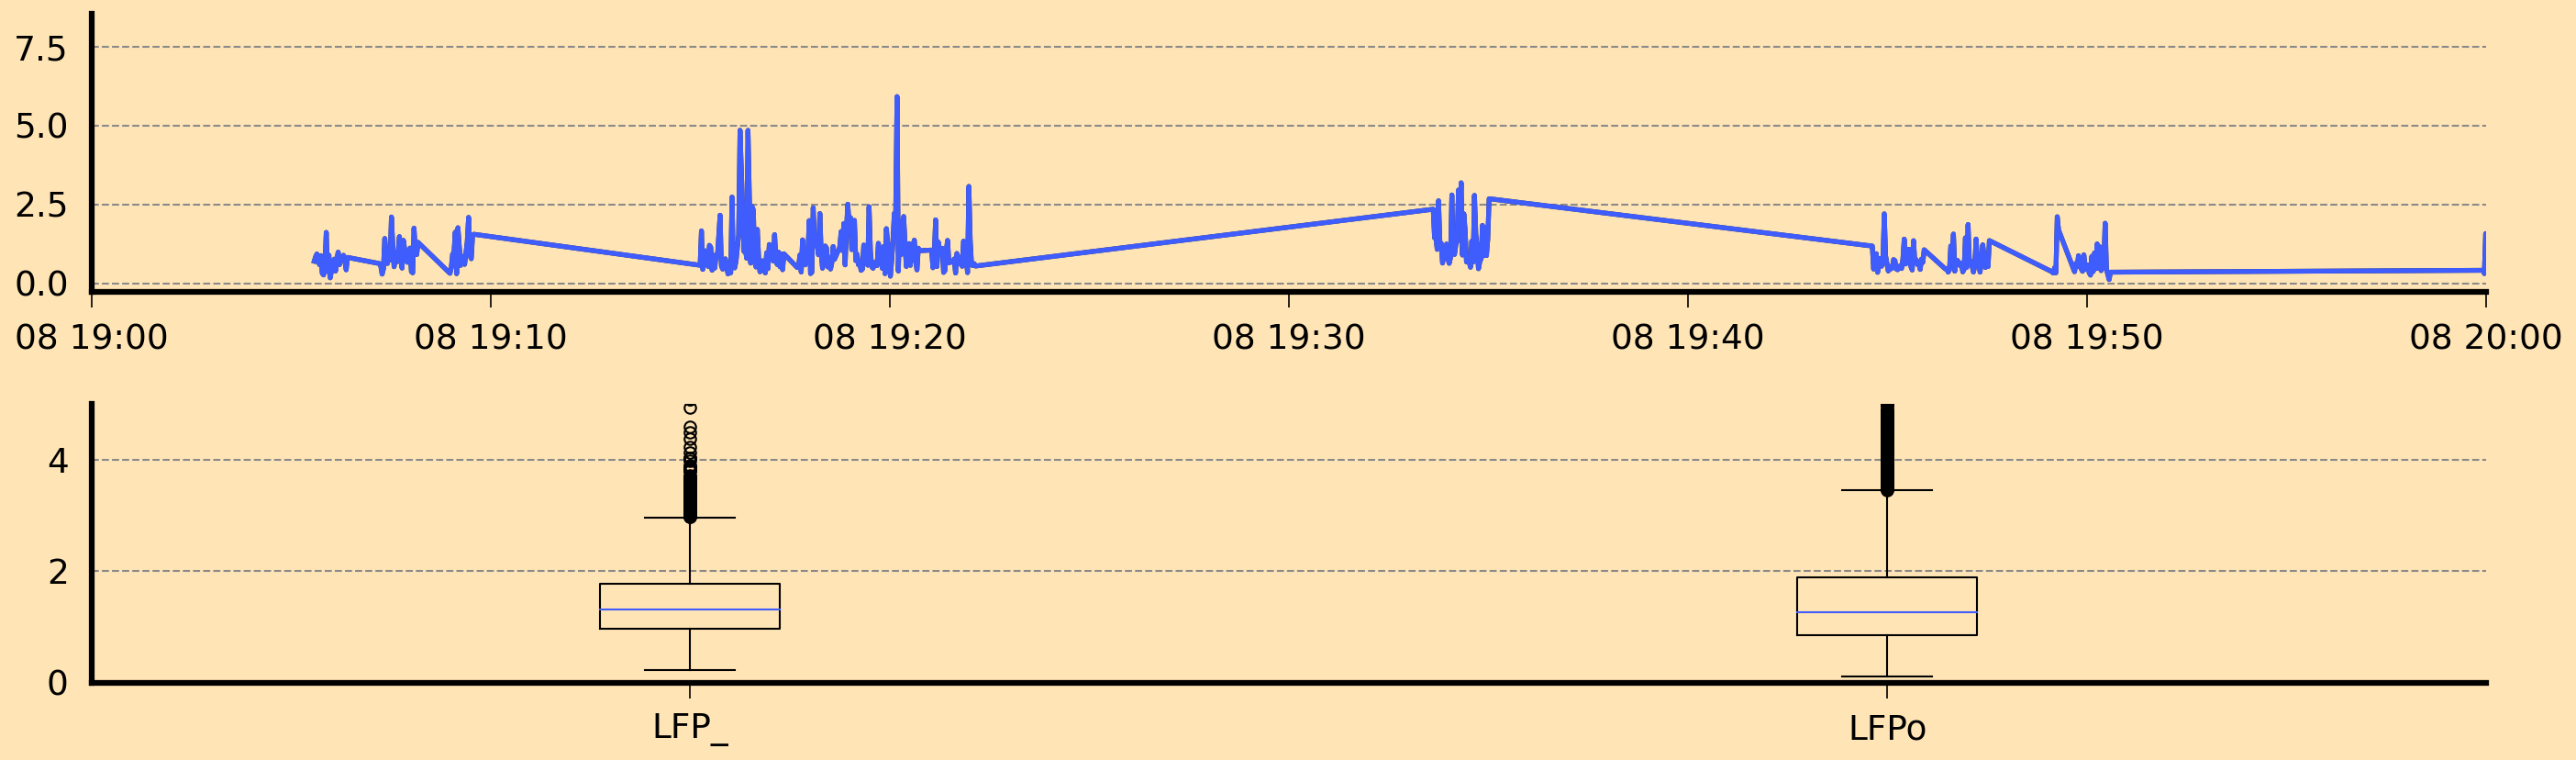

In [49]:
f, ax = plt.subplots(2, 1, sharex=False, figsize=(20, 6))
ax[0].plot(dp_rel['laser1-bl-LFP_'].xs(13, level='channel').filt_state().index, dp_rel['laser1-bl-LFPo'].filt_state().xs(13, level='channel').delta)
ax[0].plot(dp_rel['laser1-bl-LFPo'].xs(13, level='channel').filt_state().index, dp_rel['laser1-bl-LFPo'].filt_state().xs(13, level='channel').delta)
ax[1].boxplot([dp_rel['laser1-bl-LFP_'].filt_state().xs(13, level='channel').delta, dp_rel['laser1-bl-LFPo'].filt_state().xs(13, level='channel').delta], labels=['LFP_', 'LFPo'])
ax[1].set_ylim(0, 5)
ax[0].set_xlim(np.datetime64('2022-09-08 19:00'), np.datetime64('2022-09-08 20:00'))

# ------------

In [7]:
d = dp['laser1-LFP_']

In [13]:
dtx = ('2022-09-09 11:00', '2022-09-09 11:25')

In [22]:
d.ri().set_index(['datetime', 'channel', 'state', 'time', 'timedelta'])

delta  \
datetime                      channel state time         timedelta                                 
2022-09-09 11:00:02.000691507 3       Wake  14029.000693 0 days 00:00:00             4284.347168   
                              13      Wake  14029.000693 0 days 00:00:00             7584.354004   
2022-09-09 11:00:04.001177906 3       Wake  14031.001179 0 days 00:00:02.000486399   9707.820312   
                              13      Wake  14031.001179 0 days 00:00:02.000486399  11407.999023   
2022-09-09 11:00:06.001664304 3       Wake  14033.001665 0 days 00:00:04.000972797  10555.964844   
...                                                                                          ...   
2022-09-09 11:59:52.873776566 13      Wake  17619.873778 0 days 00:59:50.873085059  19378.417969   
2022-09-09 11:59:54.874262964 3       Wake  17621.874264 0 days 00:59:52.873571457   8686.322266   
                              13      Wake  17621.874264 0 days 00:59:52.873571457  15038.190430   
2022-09-09 11:59:56.874749362 3       Wake  17623.874750 0 days 00:59:54.874057855  16495.220703   
                              13      Wake  17623.874750 0 days 00:59:54.874057855  34182.710938   

                                                                                          delta1  \
datetime                      channel state time         timedelta                                 
2022-09-09 11:00:02.000691507 3       Wake  14029.000693 0 days 00:00:00              536.854126   
                              13      Wake  14029.000693 0 days 00:00:00             1718.521362   
2022-09-09 11:00:04.001177906 3       Wake  14031.001179 0 days 00:00:02.000486399   4176.697754   
                              13      Wake  14031.001179 0 days 00:00:02.000486399   5313.722656   
2022-09-09 11:00:06.001664304 3       Wake  14033.001665 0 days 00:00:04.000972797   5548.014648   
...                                                                                          ...   
2022-09-09 11:59:52.873776566 13      Wake  17619.873778 0 days 00:59:50.873085059   3861.178711   
2022-09-09 11:59:54.874262964 3       Wake  17621.874264 0 days 00:59:52.873571457    992.259583   
                              13      Wake  17621.874264 0 days 00:59:52.873571457   4701.454102   
2022-09-09 11:59:56.874749362 3       Wake  17623.874750 0 days 00:59:54.874057855   4270.912109   
                              13      Wake  17623.874750 0 days 00:59:54.874057855  13267.750977   

                                                                                          delta2  \
datetime                      channel state time         timedelta                                 
2022-09-09 11:00:02.000691507 3       Wake  14029.000693 0 days 00:00:00              877.113342   
                              13      Wake  14029.000693 0 days 00:00:00             1595.109131   
2022-09-09 11:00:04.001177906 3       Wake  14031.001179 0 days 00:00:02.000486399   1217.358276   
                              13      Wake  14031.001179 0 days 00:00:02.000486399   1518.770752   
2022-09-09 11:00:06.001664304 3       Wake  14033.001665 0 days 00:00:04.000972797   2219.705078   
...                                                                                          ...   
2022-09-09 11:59:52.873776566 13      Wake  17619.873778 0 days 00:59:50.873085059  11356.798828   
2022-09-09 11:59:54.874262964 3       Wake  17621.874264 0 days 00:59:52.873571457   2052.577148   
                              13      Wake  17621.874264 0 days 00:59:52.873571457   4739.157715   
2022-09-09 11:59:56.874749362 3       Wake  17623.874750 0 days 00:59:54.874057855   2825.963379   
                              13      Wake  17623.874750 0 days 00:59:54.874057855   4191.231445   

                                                                                           theta  \
datetime                      channel state time         timedelta                      

In [27]:
acr.io.save_dataset(dp, subs.a13)

laser1-LFP_ saved
